In [1]:
from utils.util import mkdir,seed_all
from omegaconf import OmegaConf
from cprint import *
from datasets.shape_net import ShapeNet
import torch
from models.Transform2D import Transform2D
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from utils.visualizations import save_voxels
from PIL import Image
import os
import numpy as np
import datetime
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

## Setup Expirement Folder

In [3]:
import time
seed_all(111)
today = time.strftime("%Y-%m-%d")
config = OmegaConf.load("./configs/global_configs.yaml")
cprint.ok(config)
description = "Multi view airplanev2" # Describe Experiment params here
logs_dir = config["logs_dir"]
mkdir(logs_dir)
experiment_dir = f"{logs_dir}/{config['name']}"
mkdir(experiment_dir)
loss_log_title = "Loss Log" + today 

with open(f"{experiment_dir}/description.txt", "w") as file1:
    file1.write(description)
    
with open(f"{experiment_dir}/configs.txt", "w") as file1:
    file1.write(str(config))

with open(f"{experiment_dir}/loss_log.txt", "w") as file1:
    file1.write(loss_log_title)
    file1.write("\n")


mkdir(f"{experiment_dir}/checkpoints")
mkdir(f"{experiment_dir}/tb")
mkdir(f"{experiment_dir}/visuals")

{'logs_dir': 'logs', 'is_train': True, 'name': 'multiViewAirPlane', 'device': 'cuda:0', 'batch_size': 8, 'n_epochs': 100, 'print_every': 300, 'validate_every': 3000, 'save_every': 3000, 'save_every_nepochs': 10, 'model': {'lr': 0.0001, 'criterion': 'BCE', 'pos_weight': 1.3, 'encoder': {'patch_size': 13, 'sequence_length': 100, 'embedding_dim': 768, 'patch_padding': 3}, 'transformer_encoder': {'d_model': 768, 'nhead': 12, 'num_layers': 12}, 'transformer_decoder': {'d_model': 768, 'nhead': 12, 'num_layers': 8, 'num_pos_embeddings': 64}}}
- logs directory found
- logs/multiViewAirPlane directory found
- logs/multiViewAirPlane/checkpoints directory found
- logs/multiViewAirPlane/tb directory found
- logs/multiViewAirPlane/visuals directory found


## Load Dataset & Dataloaders
This uses a random split for train/validation/test - might need to look into paper if they have a pre-defined split

In [5]:
dataset = ShapeNet(cat="airplane",is_overfit=False, nimgs=10) #Change overfit param here & cat here
print('length: ', len(dataset))
dataset[0]
train_ds, valid_ds, test_ds = torch.utils.data.random_split(
    dataset, [3800, 245, 0])

train_dataloader = torch.utils.data.DataLoader(
        train_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        #num_workers=4,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )

validation_dataloader = torch.utils.data.DataLoader(
        train_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        #num_workers=4,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )


length:  4045


## Loading Model

In [6]:
model = Transform2D()
# Declare device
device = torch.device('cpu')
if torch.cuda.is_available() and config['device'].startswith('cuda'):
    device = torch.device(config['device'])
    cprint.ok('Using device:', config['device'])
else:
    cprint.warn('Using CPU')

model.to(device)


Using device: cuda:0


Transform2D(
  (patch_encoder): PatchEncoder(
    (pos_embedding): Embedding(100, 768)
    (patch_embed): PatchEmbed(
      (proj): Conv2d(4, 768, kernel_size=(13, 13), stride=(13, 13))
      (norm): Identity()
    )
  )
  (transformer_encoder): TransformerEncoder(
    (net): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): Transf

## Training

Checklist:
- Add tensorboard and make sure it logs to the `${experiment_dir}/tb` folder
- Visualize some reconstructions on validation set and make sure it logs to the `${expirement_dir}/visuals` folders

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

tensor(0.0824, device='cuda:0')


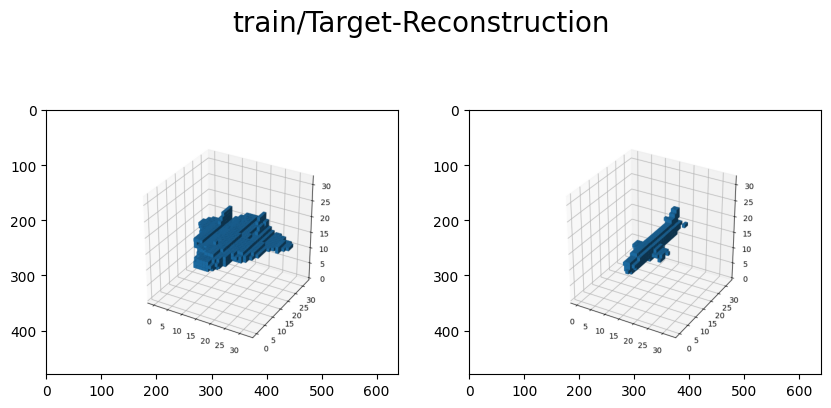

logs/multiViewAirPlane/visuals/train_299 saved


[000/00299] train_loss: 0.122550


logs/multiViewAirPlane/checkpoints/epoch-0.ckpt created


0it [00:00, ?it/s]

tensor(0.0595, device='cuda:0')


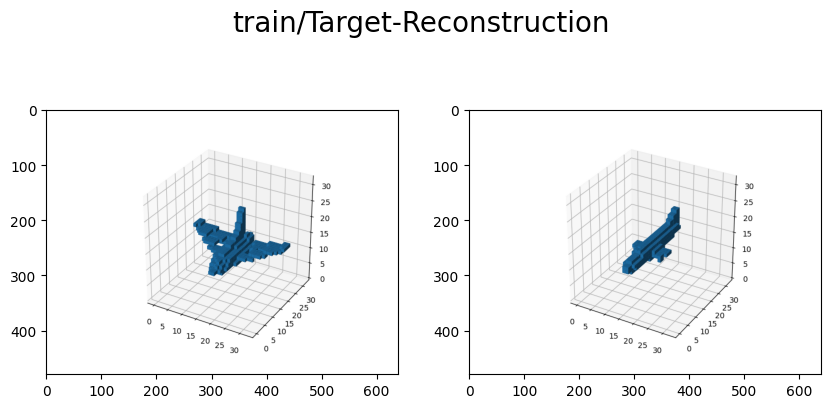

logs/multiViewAirPlane/visuals/train_599 saved


[001/00124] train_loss: 0.062051


tensor(0.0656, device='cuda:0')


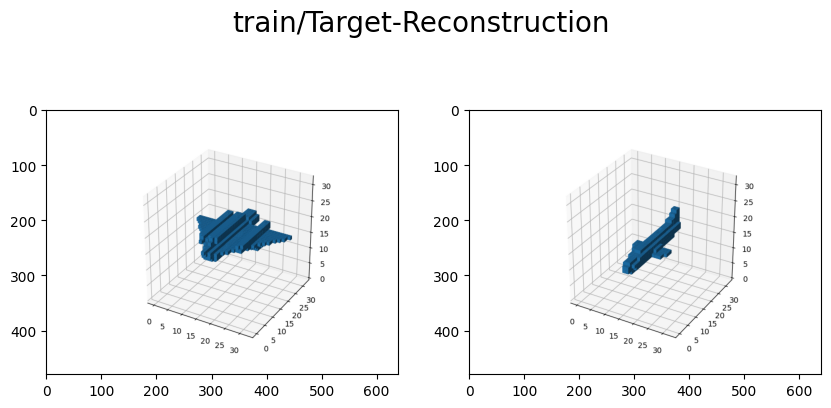

logs/multiViewAirPlane/visuals/train_899 saved


[001/00424] train_loss: 0.062257


0it [00:00, ?it/s]

tensor(0.0644, device='cuda:0')


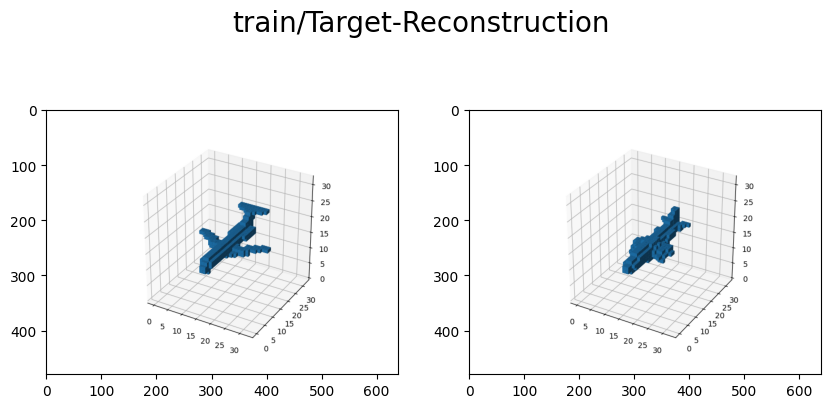

logs/multiViewAirPlane/visuals/train_1199 saved


[002/00249] train_loss: 0.062248


0it [00:00, ?it/s]

tensor(0.0558, device='cuda:0')


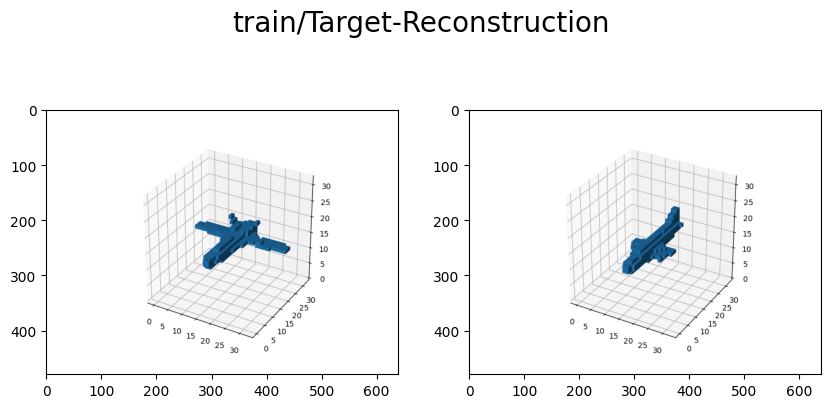

logs/multiViewAirPlane/visuals/train_1499 saved


[003/00074] train_loss: 0.060866


tensor(0.0553, device='cuda:0')


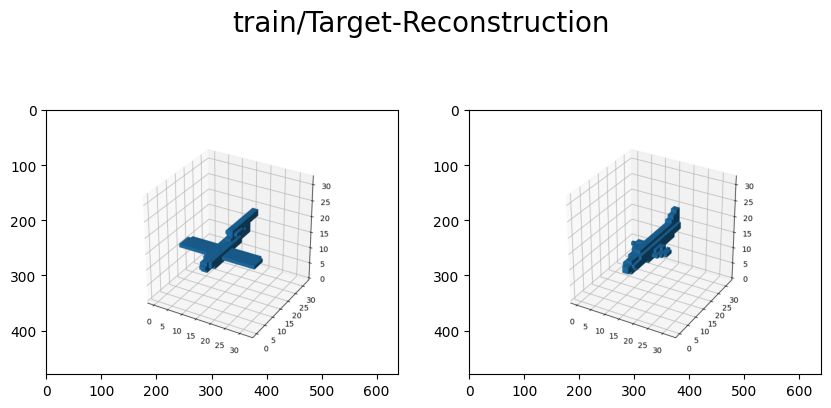

logs/multiViewAirPlane/visuals/train_1799 saved


[003/00374] train_loss: 0.061180


0it [00:00, ?it/s]

tensor(0.0523, device='cuda:0')


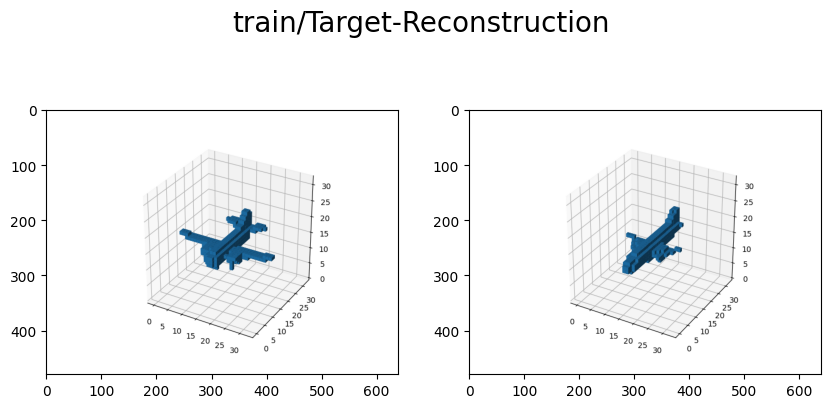

logs/multiViewAirPlane/visuals/train_2099 saved


[004/00199] train_loss: 0.059959


0it [00:00, ?it/s]

tensor(0.0504, device='cuda:0')


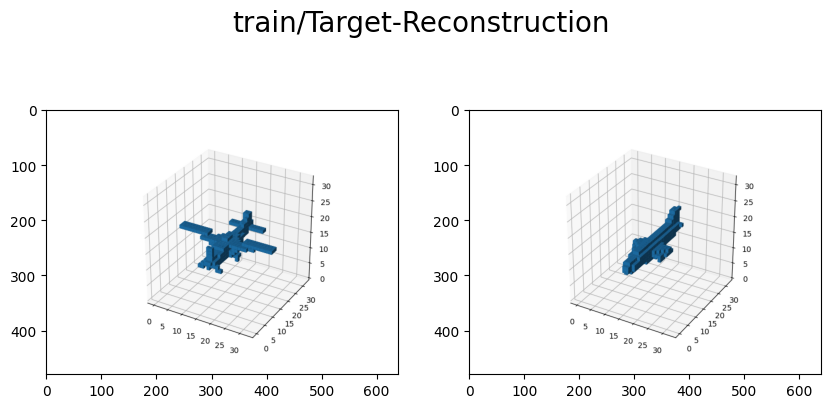

logs/multiViewAirPlane/visuals/train_2399 saved


[005/00024] train_loss: 0.058311


tensor(0.0637, device='cuda:0')


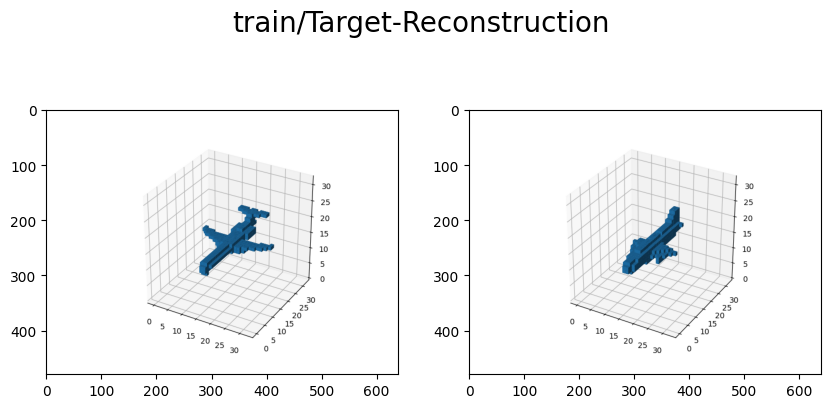

logs/multiViewAirPlane/visuals/train_2699 saved


[005/00324] train_loss: 0.061671


0it [00:00, ?it/s]

tensor(0.0487, device='cuda:0')


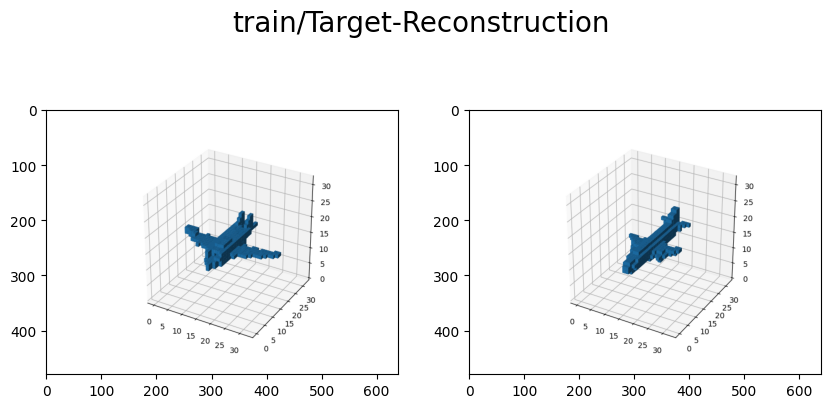

logs/multiViewAirPlane/visuals/train_2999 saved
logs/multiViewAirPlane/checkpoints/epoch-latest.ckpt created


[006/00149] train_loss: 0.061720


Running Validation


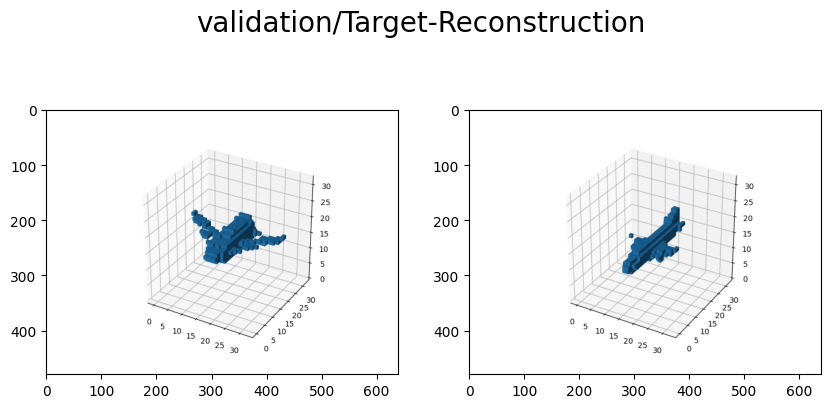

logs/multiViewAirPlane/visuals/validation_2999 saved
logs/multiViewAirPlane/checkpoints/epoch-best.ckpt created


[006/00149] val_loss: 0.060834 | best_loss_val: 0.060834


0it [00:00, ?it/s]

tensor(0.0658, device='cuda:0')


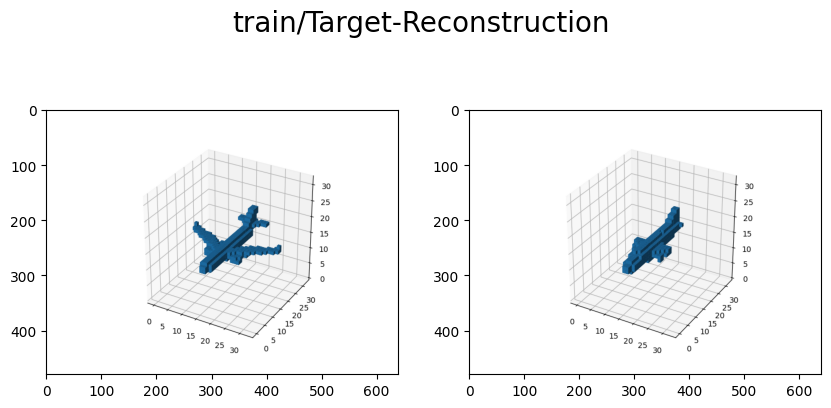

logs/multiViewAirPlane/visuals/train_3599 saved


[007/00274] train_loss: 0.061187


0it [00:00, ?it/s]

tensor(0.0502, device='cuda:0')


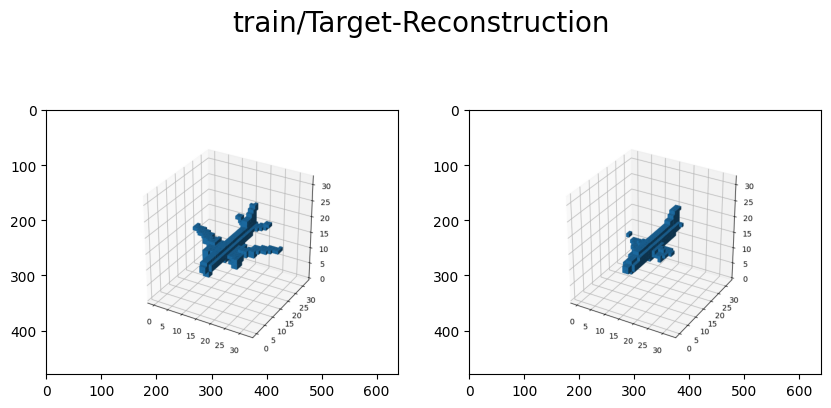

logs/multiViewAirPlane/visuals/train_3899 saved


[008/00099] train_loss: 0.063109


tensor(0.0470, device='cuda:0')


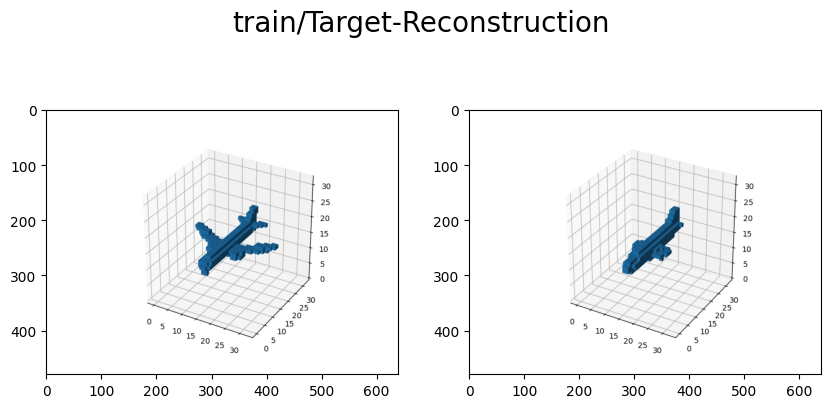

logs/multiViewAirPlane/visuals/train_4199 saved


[008/00399] train_loss: 0.060721


0it [00:00, ?it/s]

tensor(0.0612, device='cuda:0')


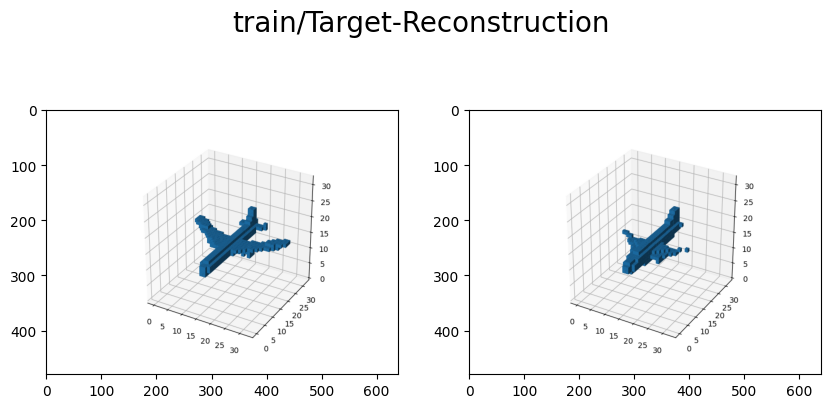

logs/multiViewAirPlane/visuals/train_4499 saved


[009/00224] train_loss: 0.060208


0it [00:00, ?it/s]

tensor(0.0745, device='cuda:0')


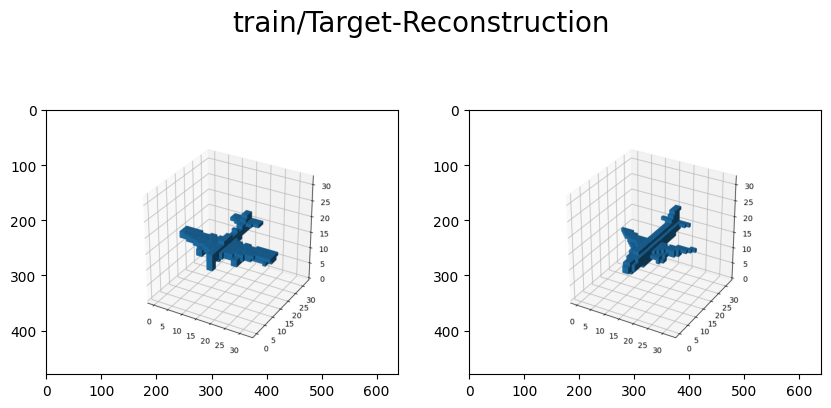

logs/multiViewAirPlane/visuals/train_4799 saved


[010/00049] train_loss: 0.061978


tensor(0.0572, device='cuda:0')


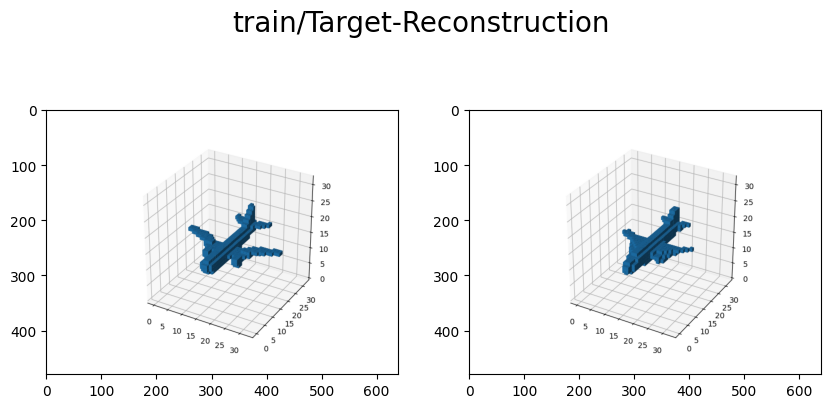

logs/multiViewAirPlane/visuals/train_5099 saved


[010/00349] train_loss: 0.061314


logs/multiViewAirPlane/checkpoints/epoch-10.ckpt created


0it [00:00, ?it/s]

tensor(0.0721, device='cuda:0')


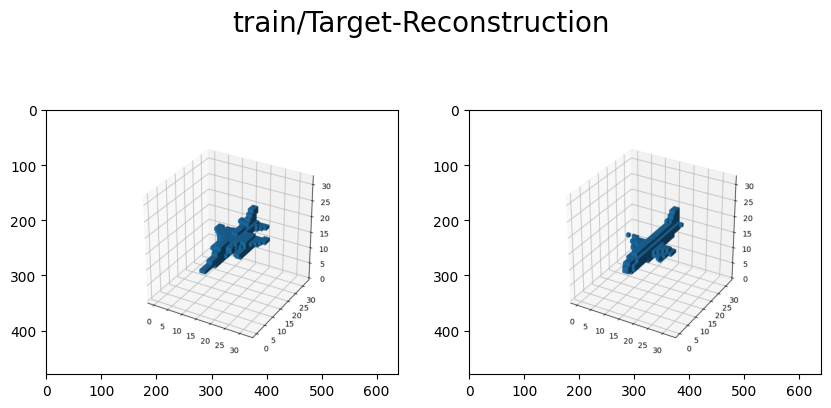

logs/multiViewAirPlane/visuals/train_5399 saved


[011/00174] train_loss: 0.061993


tensor(0.0500, device='cuda:0')


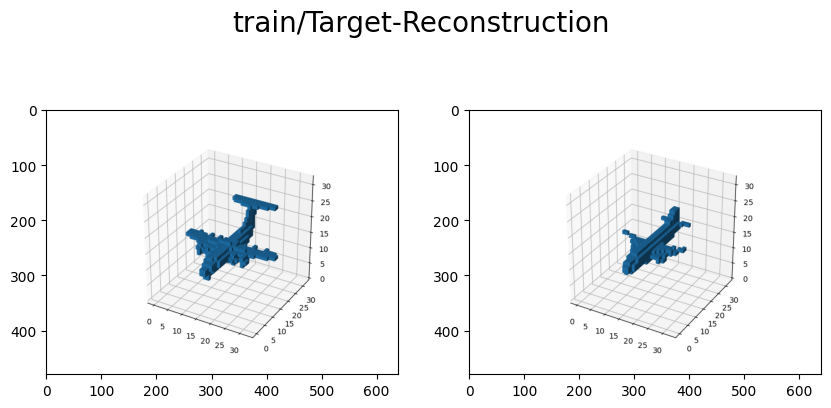

logs/multiViewAirPlane/visuals/train_5699 saved


[011/00474] train_loss: 0.060578


0it [00:00, ?it/s]

tensor(0.0583, device='cuda:0')


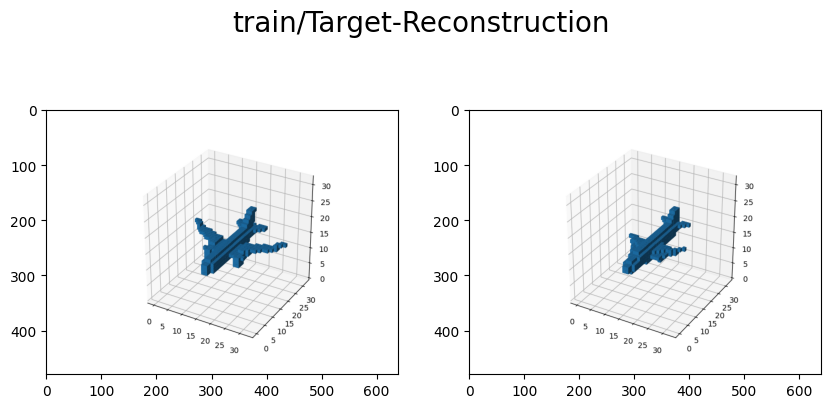

logs/multiViewAirPlane/visuals/train_5999 saved
logs/multiViewAirPlane/checkpoints/epoch-latest.ckpt created


[012/00299] train_loss: 0.060383


Running Validation


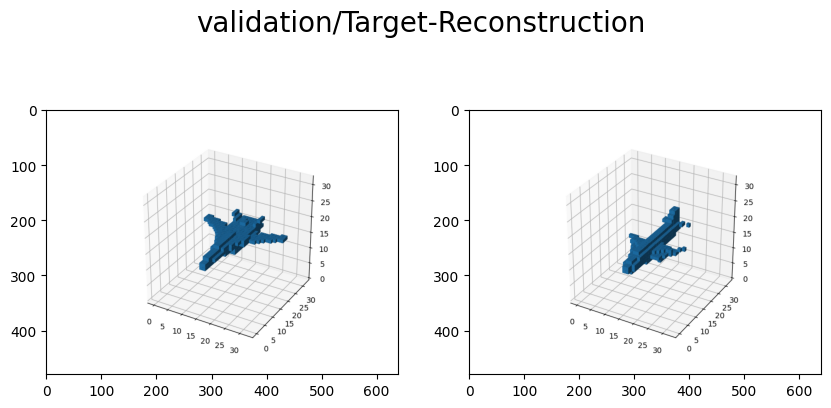

logs/multiViewAirPlane/visuals/validation_5999 saved
logs/multiViewAirPlane/checkpoints/epoch-best.ckpt created


[012/00299] val_loss: 0.060553 | best_loss_val: 0.060553


0it [00:00, ?it/s]

tensor(0.0656, device='cuda:0')


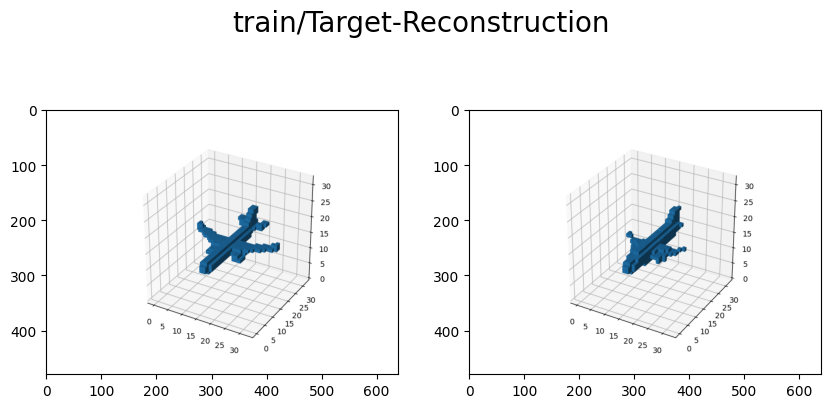

logs/multiViewAirPlane/visuals/train_6299 saved


[013/00124] train_loss: 0.062099


tensor(0.0475, device='cuda:0')


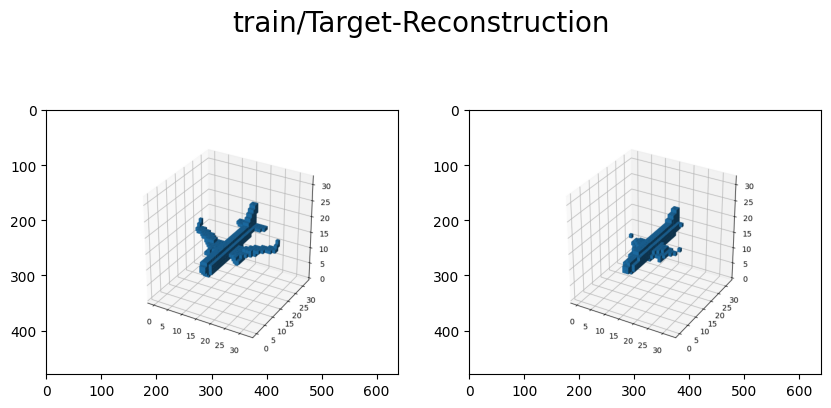

logs/multiViewAirPlane/visuals/train_6599 saved


[013/00424] train_loss: 0.061184


0it [00:00, ?it/s]

tensor(0.0606, device='cuda:0')


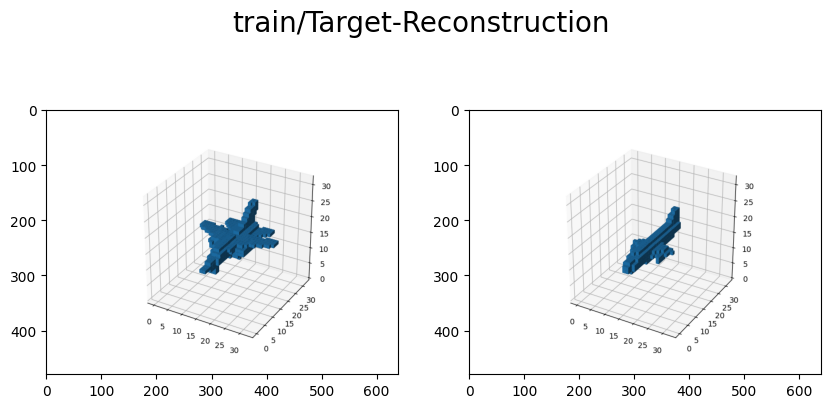

logs/multiViewAirPlane/visuals/train_6899 saved


[014/00249] train_loss: 0.061609


0it [00:00, ?it/s]

tensor(0.0451, device='cuda:0')


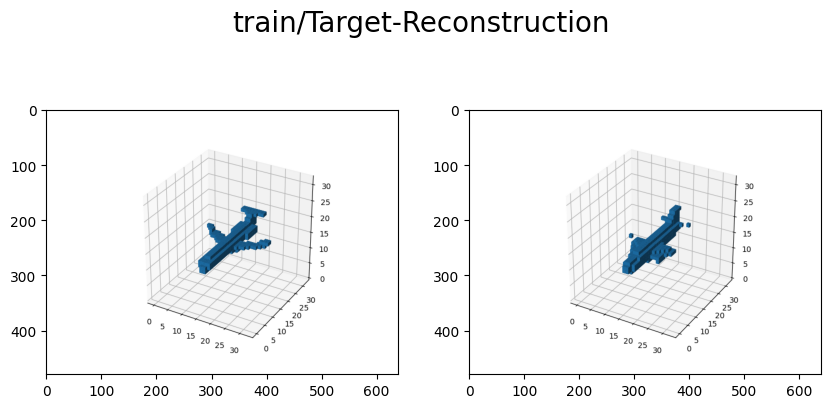

logs/multiViewAirPlane/visuals/train_7199 saved


[015/00074] train_loss: 0.059228


tensor(0.0516, device='cuda:0')


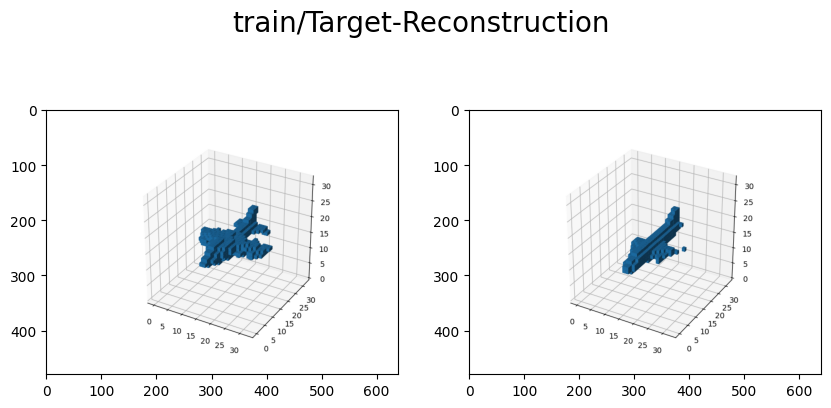

logs/multiViewAirPlane/visuals/train_7499 saved


[015/00374] train_loss: 0.061476


0it [00:00, ?it/s]

tensor(0.0592, device='cuda:0')


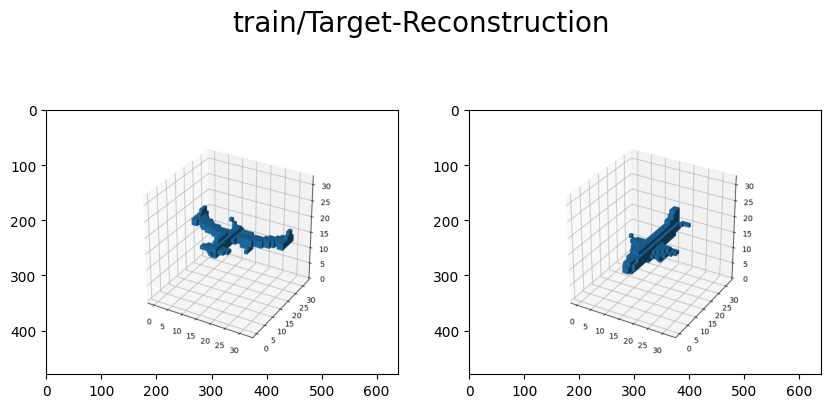

logs/multiViewAirPlane/visuals/train_7799 saved


[016/00199] train_loss: 0.061347


0it [00:00, ?it/s]

tensor(0.0555, device='cuda:0')


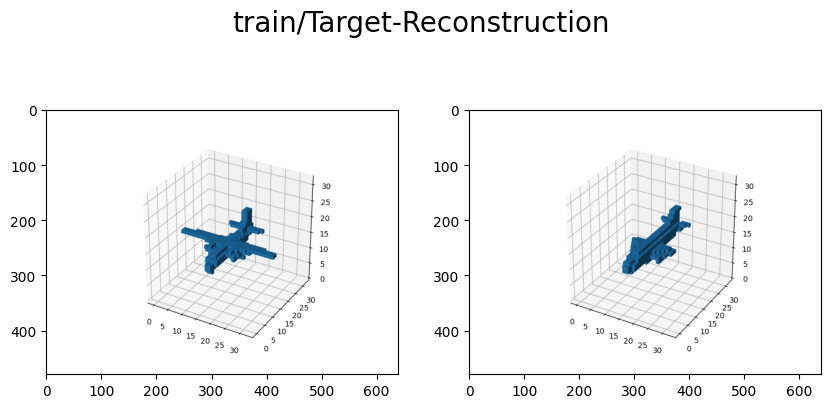

logs/multiViewAirPlane/visuals/train_8099 saved


[017/00024] train_loss: 0.058511


tensor(0.0497, device='cuda:0')


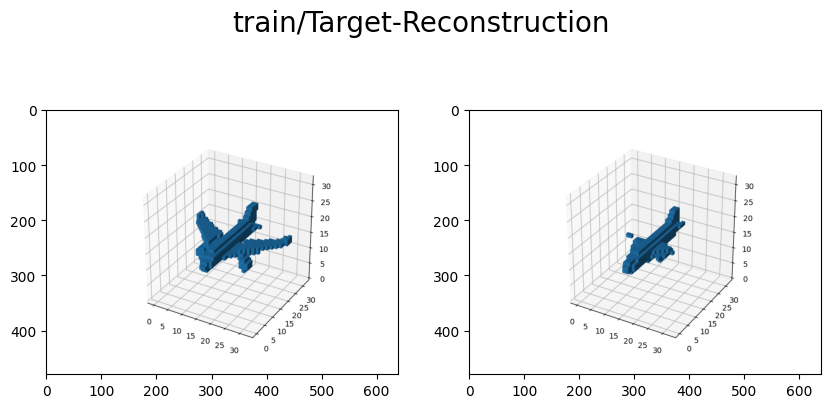

logs/multiViewAirPlane/visuals/train_8399 saved


[017/00324] train_loss: 0.061009


0it [00:00, ?it/s]

tensor(0.0820, device='cuda:0')


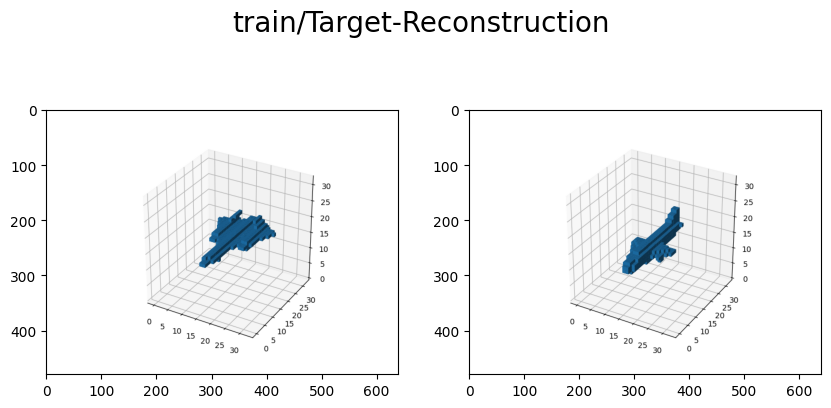

logs/multiViewAirPlane/visuals/train_8699 saved


[018/00149] train_loss: 0.061167


tensor(0.0851, device='cuda:0')


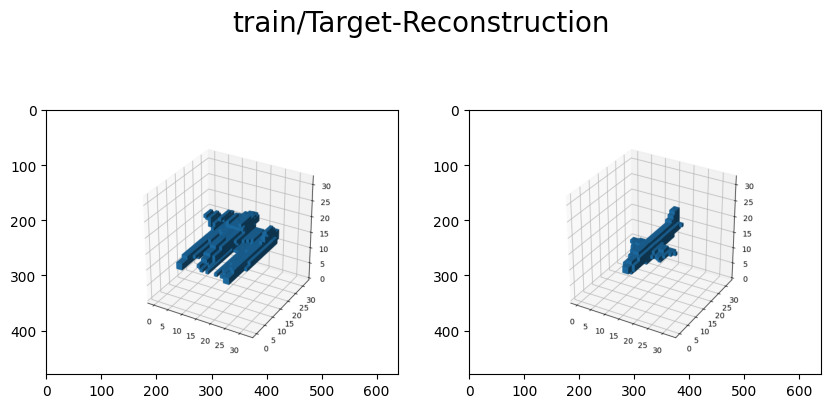

logs/multiViewAirPlane/visuals/train_8999 saved
logs/multiViewAirPlane/checkpoints/epoch-latest.ckpt created


[018/00449] train_loss: 0.060315


Running Validation


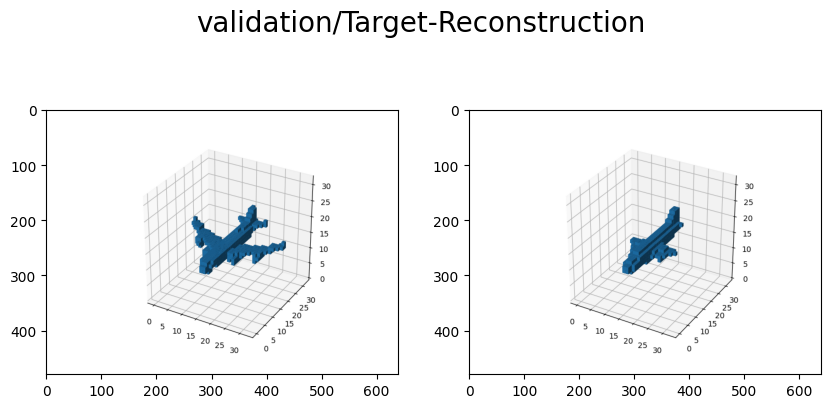

logs/multiViewAirPlane/visuals/validation_8999 saved


[018/00449] val_loss: 0.060786 | best_loss_val: 0.060553


0it [00:00, ?it/s]

tensor(0.0564, device='cuda:0')


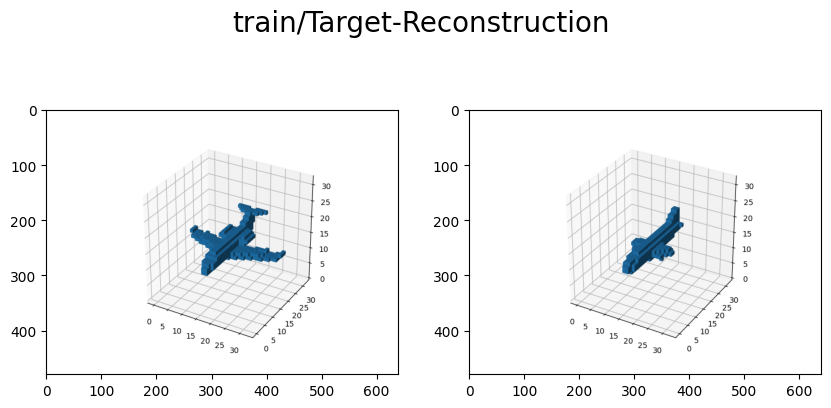

logs/multiViewAirPlane/visuals/train_9299 saved


[019/00274] train_loss: 0.060516


0it [00:00, ?it/s]

tensor(0.0602, device='cuda:0')


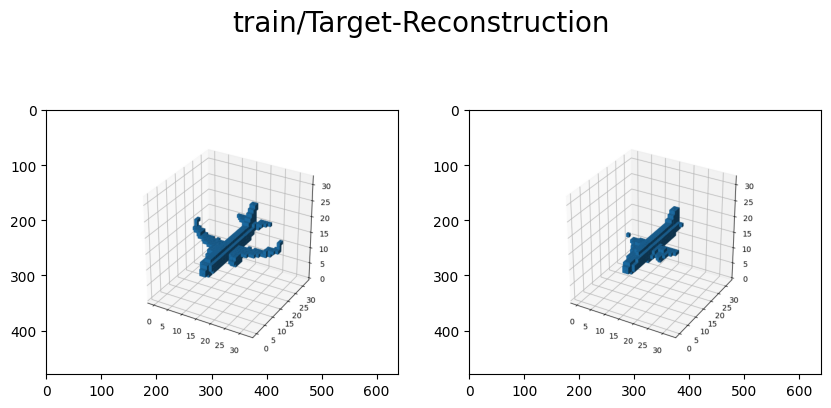

logs/multiViewAirPlane/visuals/train_9599 saved


[020/00099] train_loss: 0.061066


tensor(0.1120, device='cuda:0')


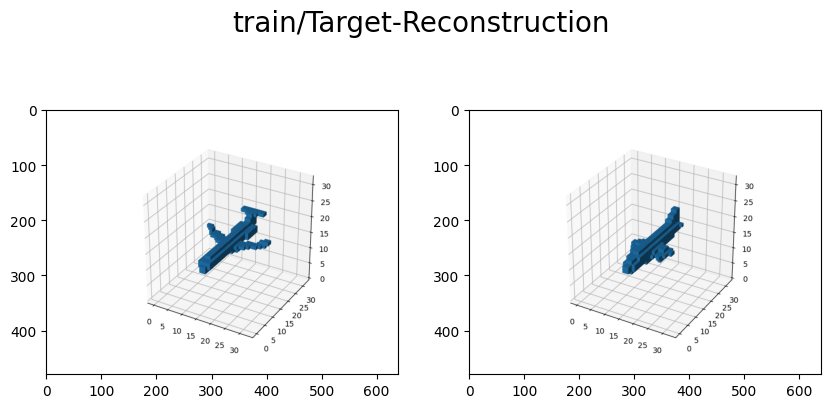

logs/multiViewAirPlane/visuals/train_9899 saved


[020/00399] train_loss: 0.060342


logs/multiViewAirPlane/checkpoints/epoch-20.ckpt created


0it [00:00, ?it/s]

tensor(0.0476, device='cuda:0')


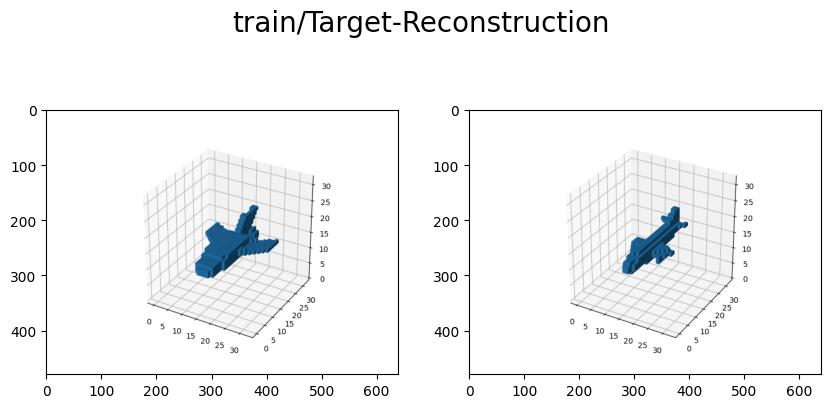

logs/multiViewAirPlane/visuals/train_10199 saved


[021/00224] train_loss: 0.060898


0it [00:00, ?it/s]

tensor(0.0573, device='cuda:0')


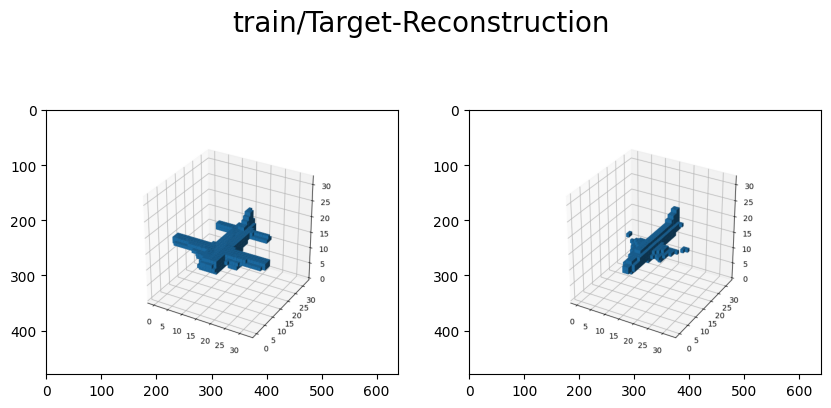

logs/multiViewAirPlane/visuals/train_10499 saved


[022/00049] train_loss: 0.058543


tensor(0.0672, device='cuda:0')


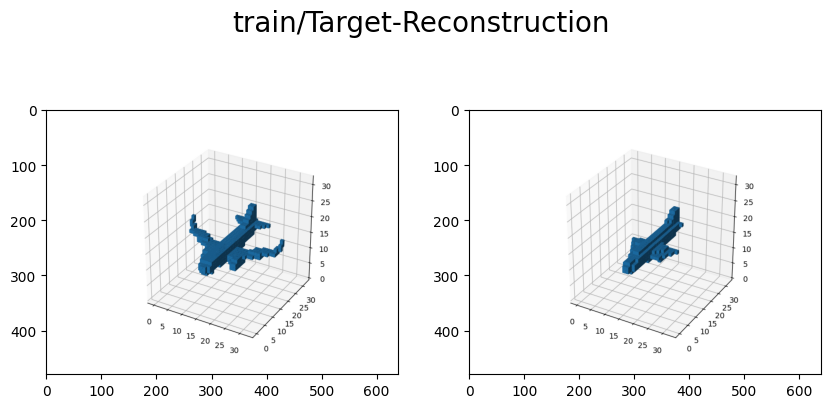

logs/multiViewAirPlane/visuals/train_10799 saved


[022/00349] train_loss: 0.061015


0it [00:00, ?it/s]

tensor(0.0496, device='cuda:0')


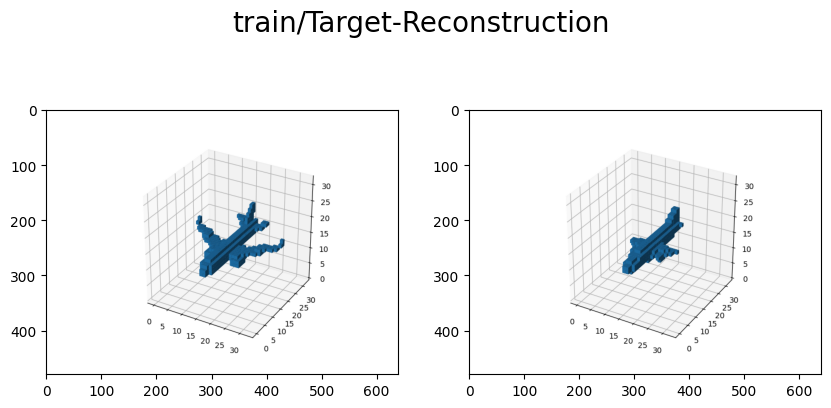

logs/multiViewAirPlane/visuals/train_11099 saved


[023/00174] train_loss: 0.058413


tensor(0.0537, device='cuda:0')


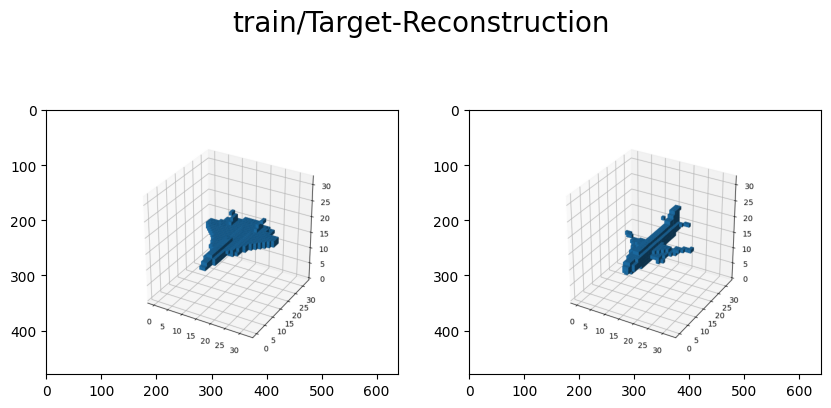

logs/multiViewAirPlane/visuals/train_11399 saved


[023/00474] train_loss: 0.061933


0it [00:00, ?it/s]

tensor(0.0546, device='cuda:0')


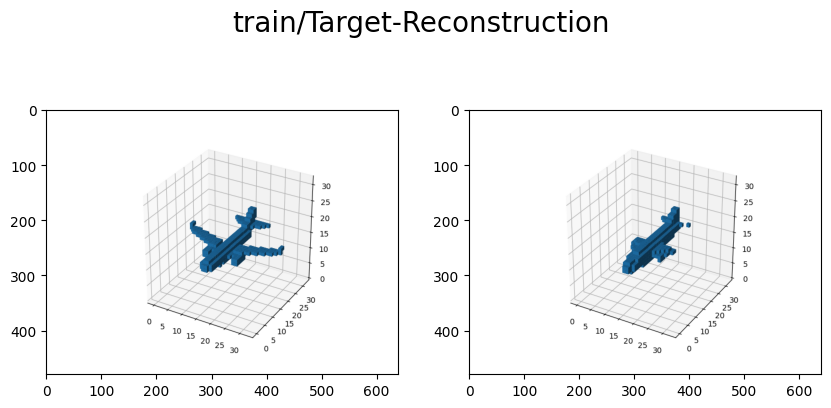

logs/multiViewAirPlane/visuals/train_11699 saved


[024/00299] train_loss: 0.061227


0it [00:00, ?it/s]

tensor(0.0457, device='cuda:0')


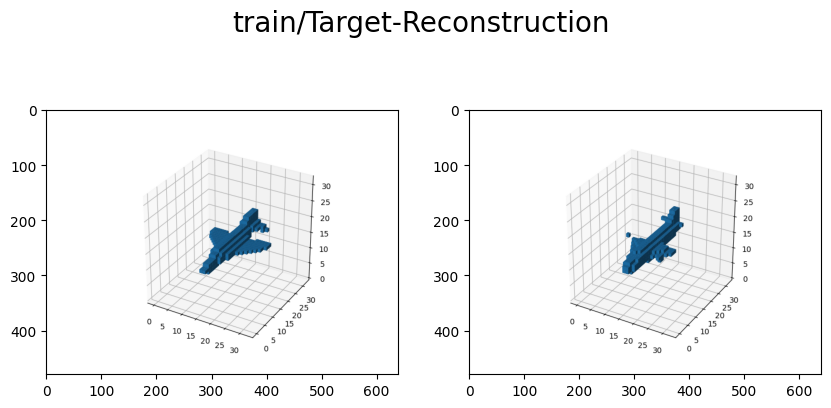

logs/multiViewAirPlane/visuals/train_11999 saved
logs/multiViewAirPlane/checkpoints/epoch-latest.ckpt created


[025/00124] train_loss: 0.060365


Running Validation


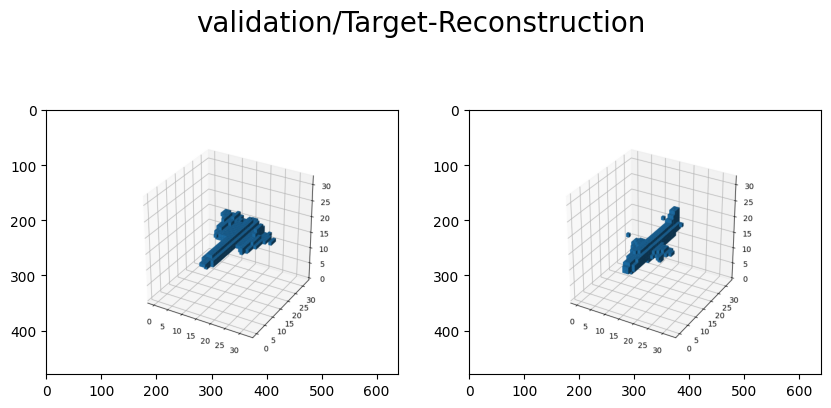

logs/multiViewAirPlane/visuals/validation_11999 saved


[025/00124] val_loss: 0.061269 | best_loss_val: 0.060553


0it [00:00, ?it/s]

tensor(0.0446, device='cuda:0')


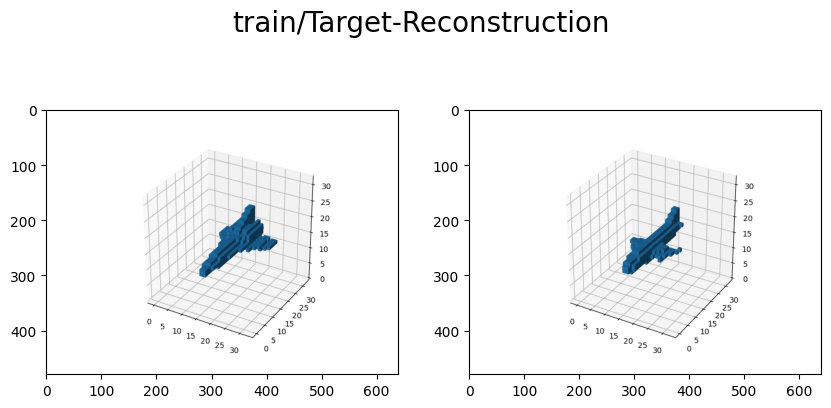

logs/multiViewAirPlane/visuals/train_12599 saved


[026/00249] train_loss: 0.060566


0it [00:00, ?it/s]

tensor(0.0422, device='cuda:0')


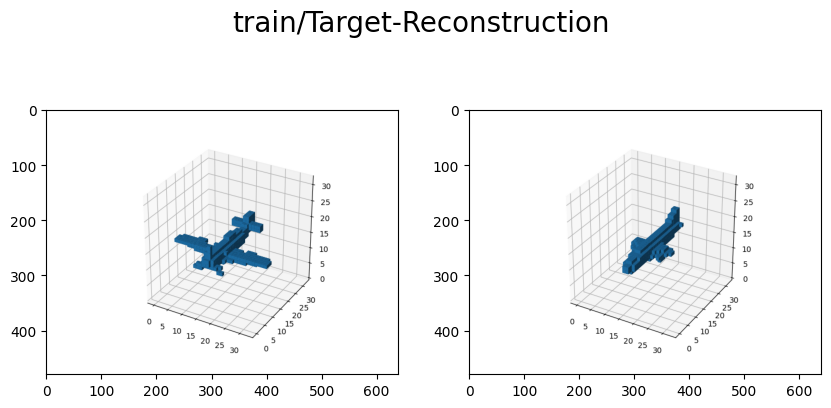

logs/multiViewAirPlane/visuals/train_12899 saved


[027/00074] train_loss: 0.062251


tensor(0.0457, device='cuda:0')


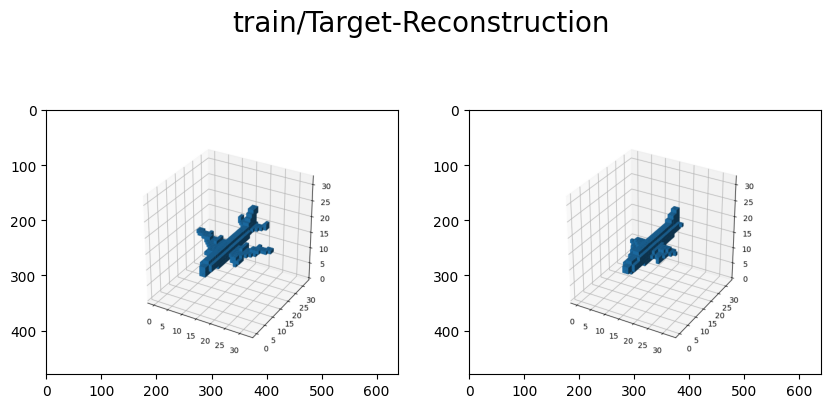

logs/multiViewAirPlane/visuals/train_13199 saved


[027/00374] train_loss: 0.060016


0it [00:00, ?it/s]

tensor(0.0494, device='cuda:0')


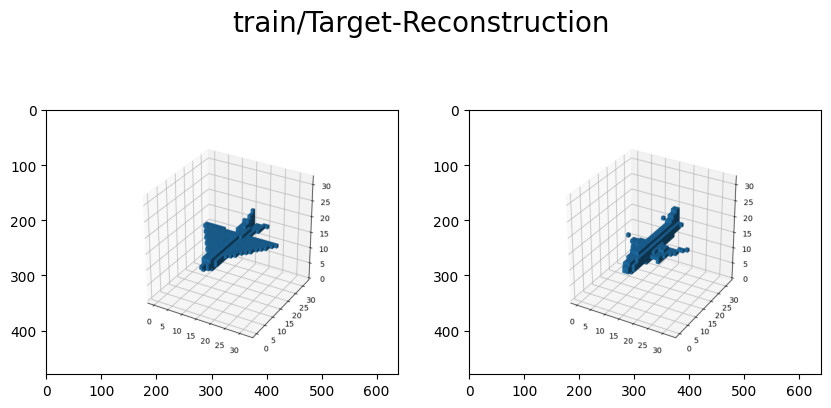

logs/multiViewAirPlane/visuals/train_13499 saved


[028/00199] train_loss: 0.059655


0it [00:00, ?it/s]

tensor(0.0659, device='cuda:0')


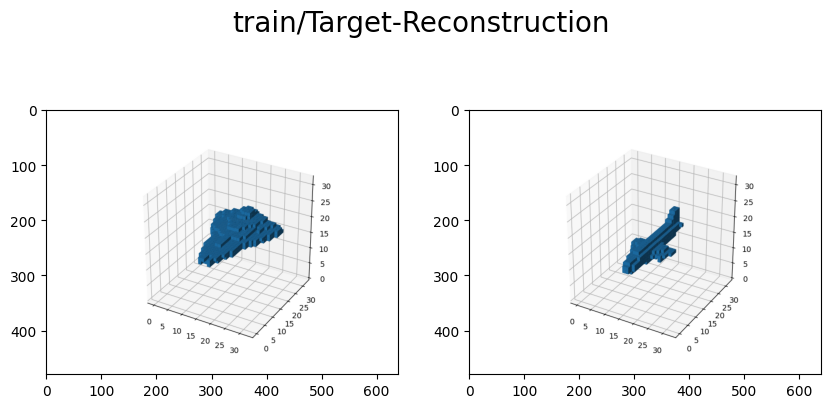

logs/multiViewAirPlane/visuals/train_13799 saved


[029/00024] train_loss: 0.059028


tensor(0.0721, device='cuda:0')


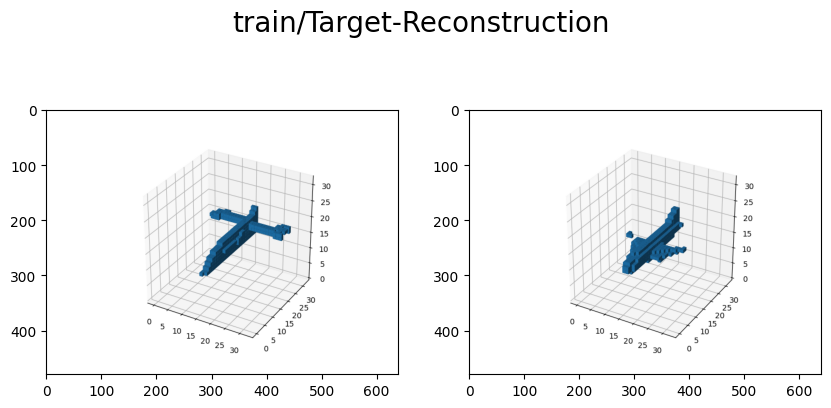

logs/multiViewAirPlane/visuals/train_14099 saved


[029/00324] train_loss: 0.059903


0it [00:00, ?it/s]

tensor(0.0759, device='cuda:0')


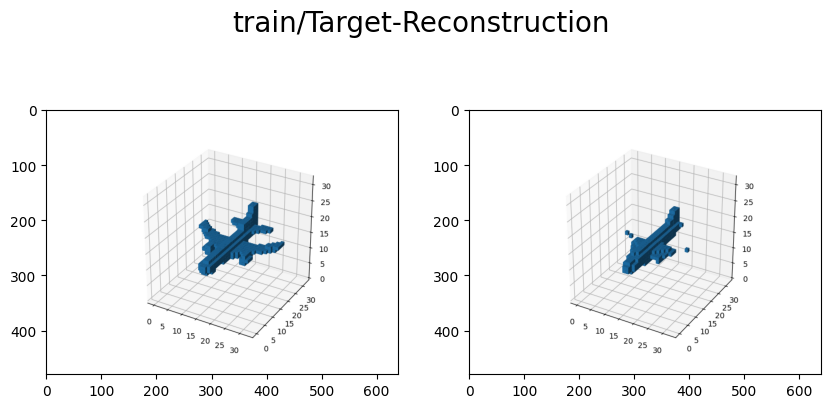

logs/multiViewAirPlane/visuals/train_14399 saved


[030/00149] train_loss: 0.059594


tensor(0.0481, device='cuda:0')


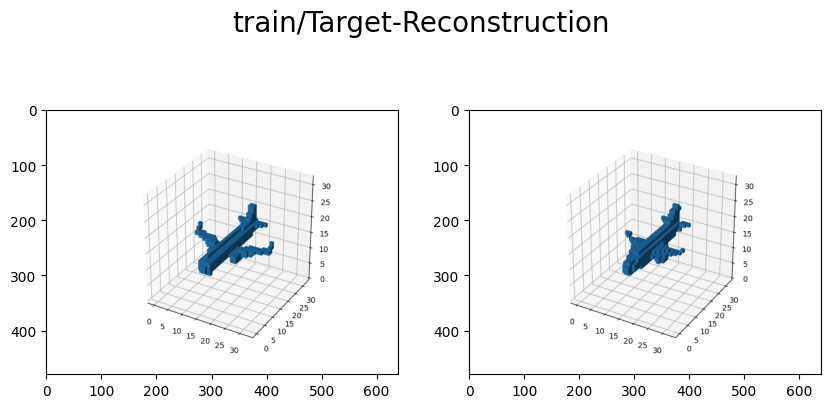

logs/multiViewAirPlane/visuals/train_14699 saved


[030/00449] train_loss: 0.060929


logs/multiViewAirPlane/checkpoints/epoch-30.ckpt created


0it [00:00, ?it/s]

tensor(0.0676, device='cuda:0')


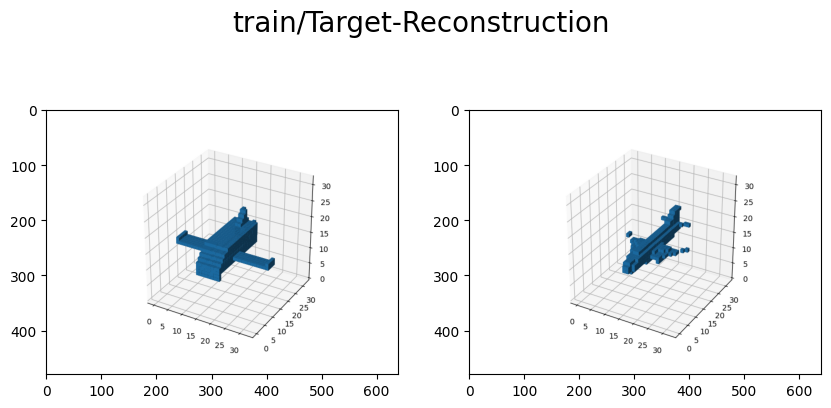

logs/multiViewAirPlane/visuals/train_14999 saved
logs/multiViewAirPlane/checkpoints/epoch-latest.ckpt created


[031/00274] train_loss: 0.060104


Running Validation


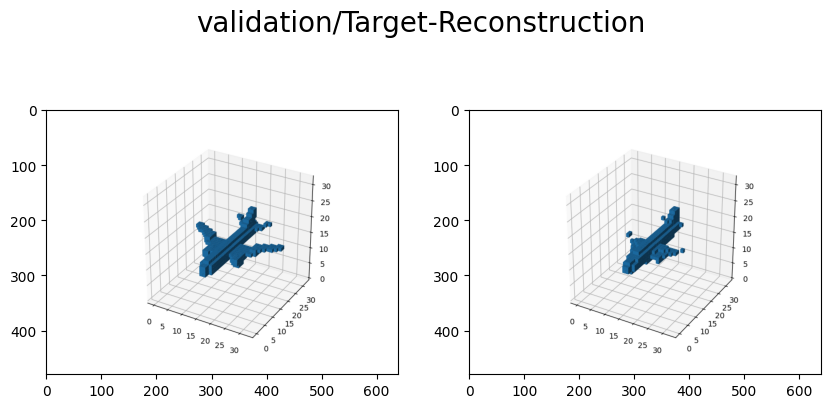

logs/multiViewAirPlane/visuals/validation_14999 saved
logs/multiViewAirPlane/checkpoints/epoch-best.ckpt created


[031/00274] val_loss: 0.060417 | best_loss_val: 0.060417


0it [00:00, ?it/s]

tensor(0.0795, device='cuda:0')


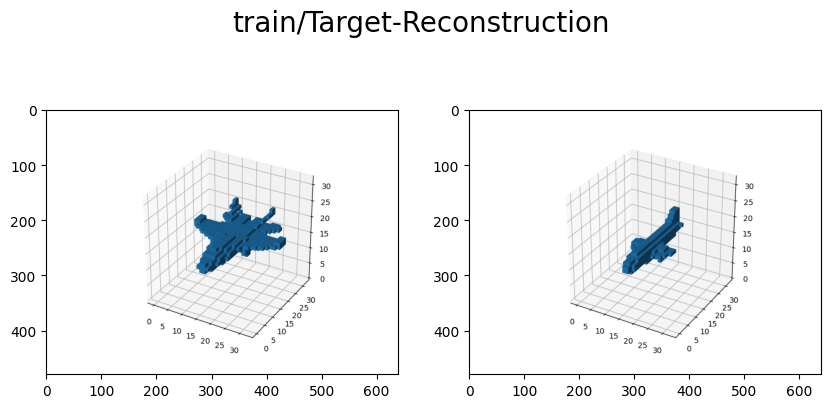

logs/multiViewAirPlane/visuals/train_15299 saved


[032/00099] train_loss: 0.060224


tensor(0.0724, device='cuda:0')


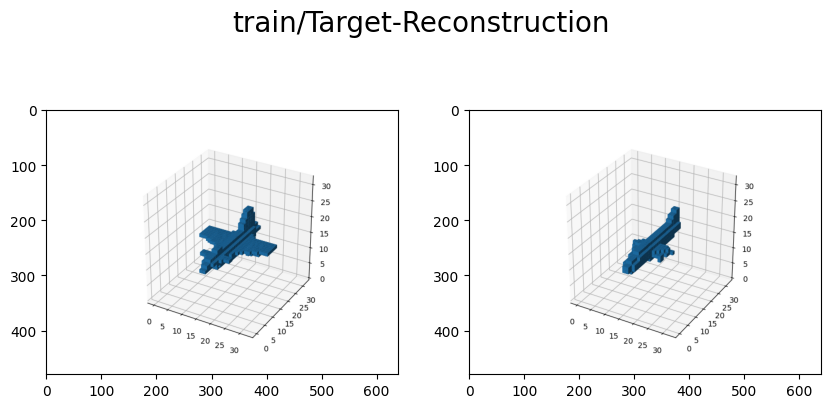

logs/multiViewAirPlane/visuals/train_15599 saved


[032/00399] train_loss: 0.061644


0it [00:00, ?it/s]

tensor(0.0767, device='cuda:0')


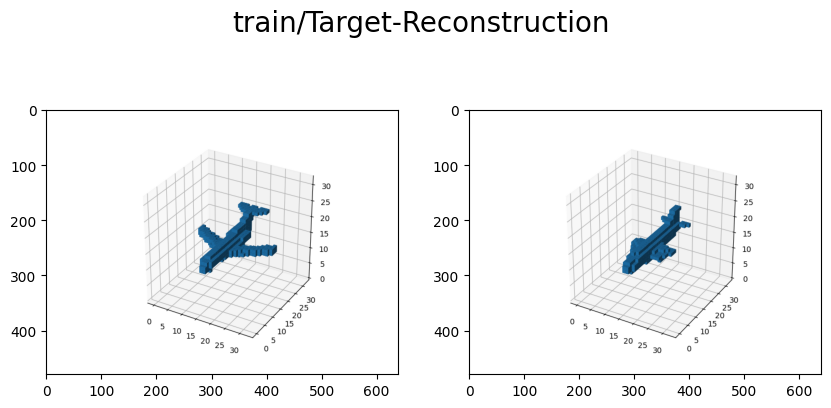

logs/multiViewAirPlane/visuals/train_15899 saved


[033/00224] train_loss: 0.060548


0it [00:00, ?it/s]

tensor(0.1064, device='cuda:0')


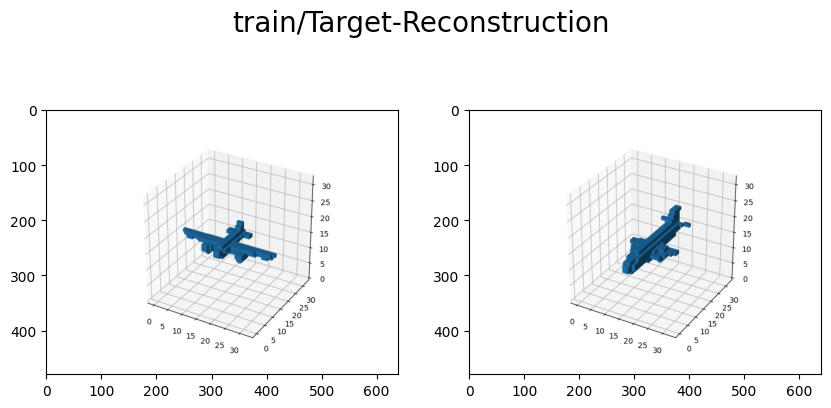

logs/multiViewAirPlane/visuals/train_16199 saved


[034/00049] train_loss: 0.060429


tensor(0.0497, device='cuda:0')


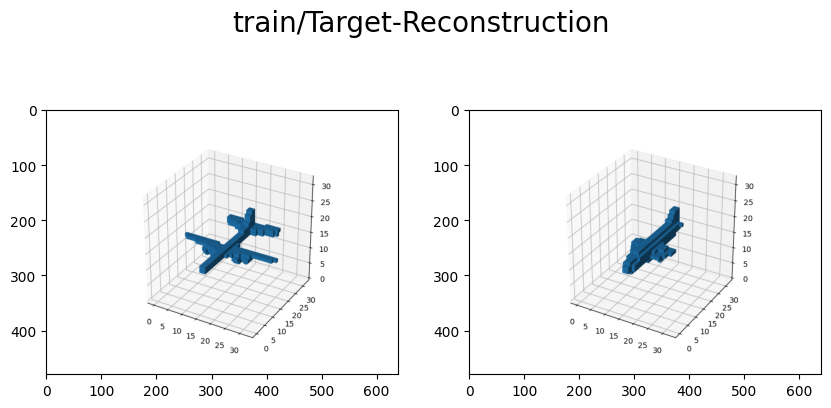

logs/multiViewAirPlane/visuals/train_16499 saved


[034/00349] train_loss: 0.060449


0it [00:00, ?it/s]

tensor(0.0612, device='cuda:0')


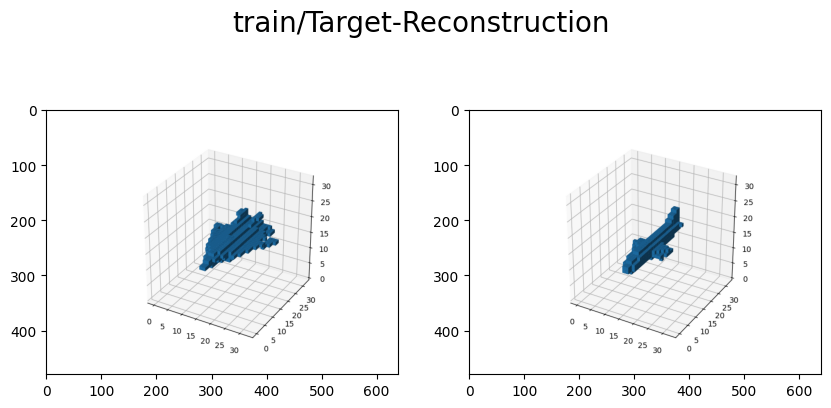

logs/multiViewAirPlane/visuals/train_16799 saved


[035/00174] train_loss: 0.062086


tensor(0.0636, device='cuda:0')


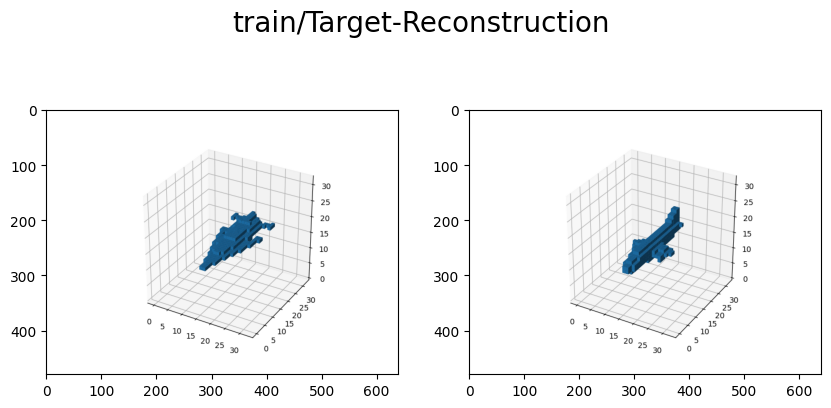

logs/multiViewAirPlane/visuals/train_17099 saved


[035/00474] train_loss: 0.059655


0it [00:00, ?it/s]

tensor(0.0629, device='cuda:0')


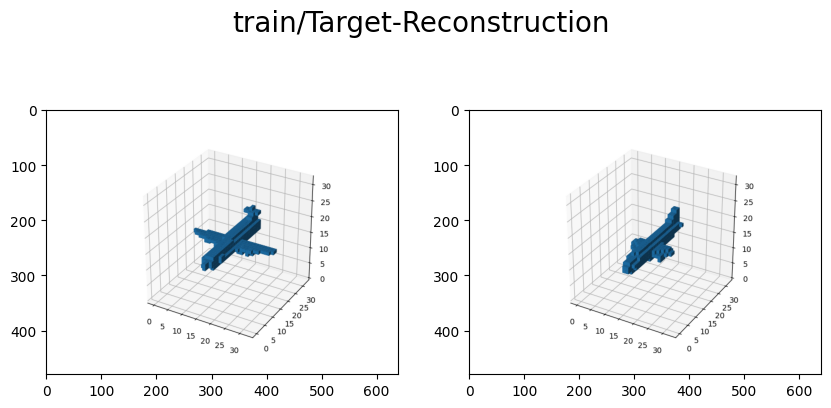

logs/multiViewAirPlane/visuals/train_17399 saved


[036/00299] train_loss: 0.060903


0it [00:00, ?it/s]

tensor(0.0500, device='cuda:0')


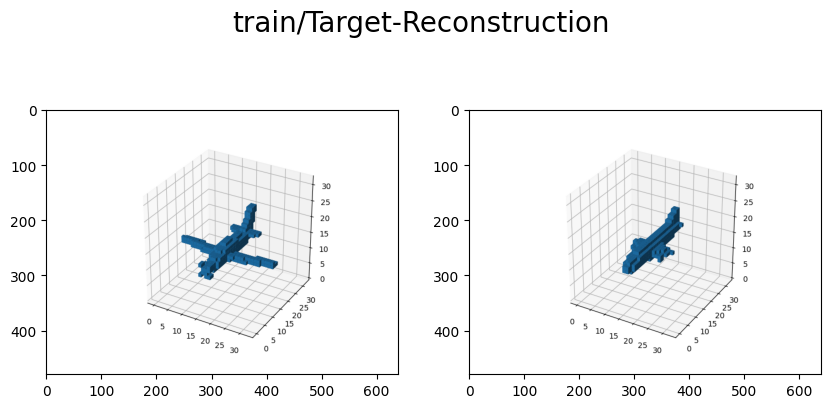

logs/multiViewAirPlane/visuals/train_17699 saved


[037/00124] train_loss: 0.059267


tensor(0.0542, device='cuda:0')


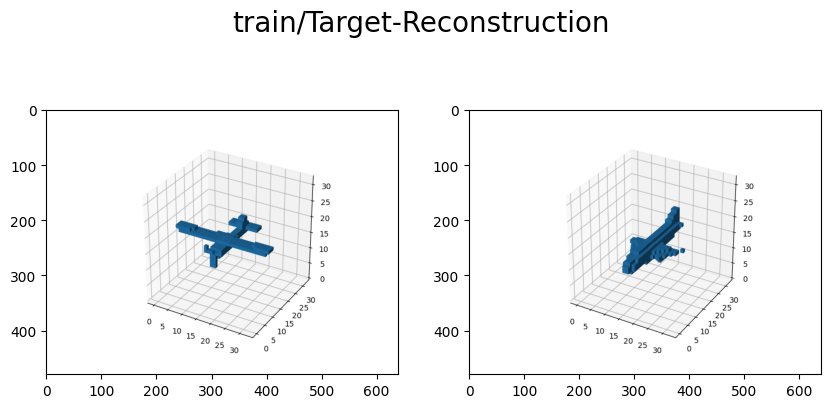

logs/multiViewAirPlane/visuals/train_17999 saved
logs/multiViewAirPlane/checkpoints/epoch-latest.ckpt created


[037/00424] train_loss: 0.061140


Running Validation


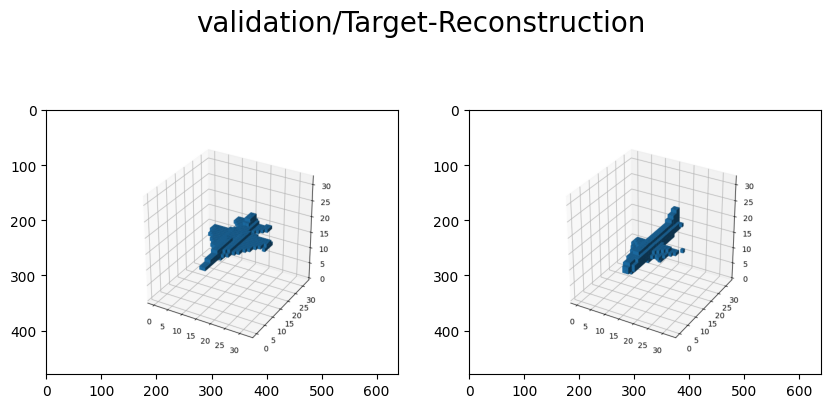

logs/multiViewAirPlane/visuals/validation_17999 saved
logs/multiViewAirPlane/checkpoints/epoch-best.ckpt created


[037/00424] val_loss: 0.060276 | best_loss_val: 0.060276


0it [00:00, ?it/s]

tensor(0.0499, device='cuda:0')


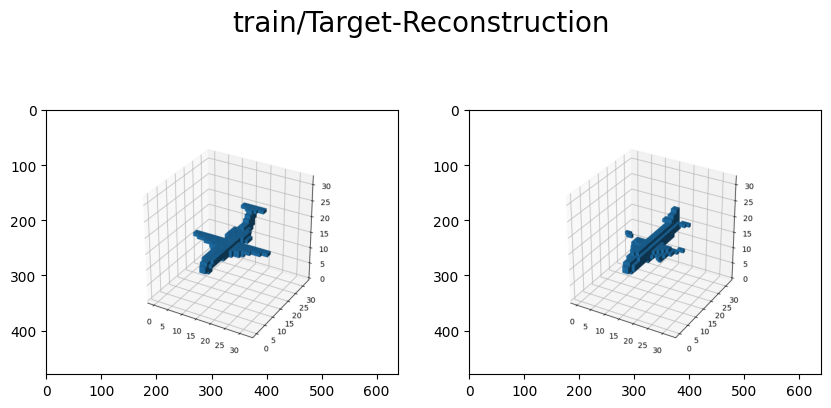

logs/multiViewAirPlane/visuals/train_18299 saved


[038/00249] train_loss: 0.060297


0it [00:00, ?it/s]

tensor(0.0409, device='cuda:0')


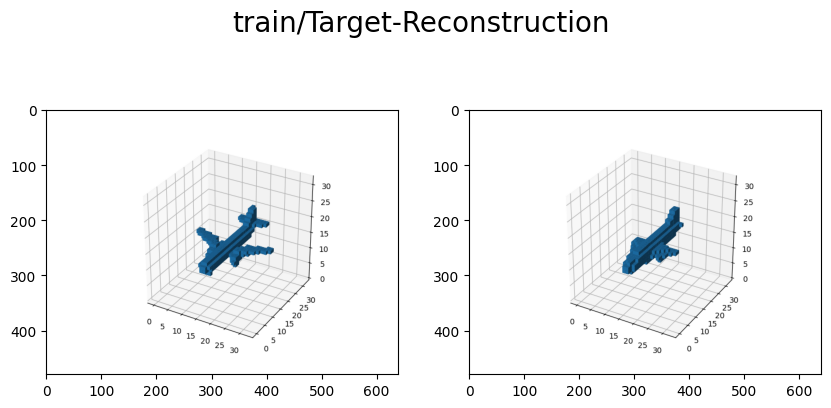

logs/multiViewAirPlane/visuals/train_18599 saved


[039/00074] train_loss: 0.060509


tensor(0.0714, device='cuda:0')


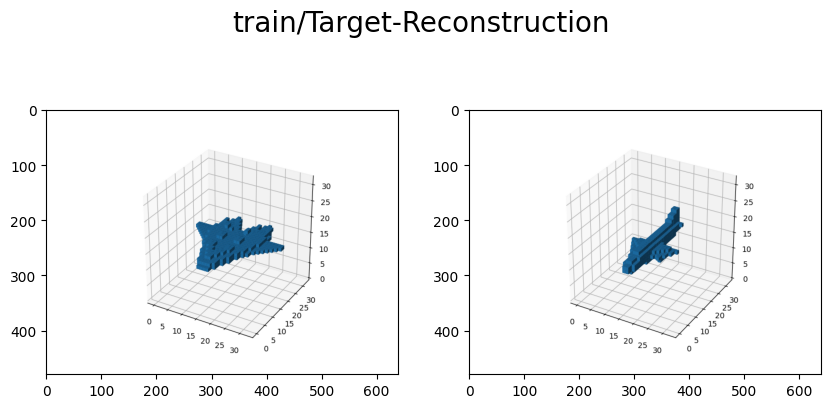

logs/multiViewAirPlane/visuals/train_18899 saved


[039/00374] train_loss: 0.060745


0it [00:00, ?it/s]

In [ ]:
from utils.visualizations import visualize_png
train_loss_running = 0.
best_loss_val = np.inf
model.train()

tb_dir = f"{experiment_dir}/tb"
writer = SummaryWriter(log_dir=tb_dir)
model_checkpoint_path = f"{experiment_dir}/checkpoints"
loss_log_name = f"{experiment_dir}/loss_log.txt"
visuals_path =  f"{experiment_dir}/visuals"
last_loss = 0.
last_iou = 0.


def train_one_epoch(epoch, writer):
     global best_loss_val
     global last_loss   
     global last_iou
     train_loss_running = 0.
     train_iou_running = 0.
     iteration_count = 0
     for batch_idx, batch in tqdm(enumerate(train_dataloader)):
         ShapeNet.move_batch_to_device(batch, device)
         model.step(batch)
         metrics = model.get_metrics()
         loss = metrics["loss"]
         iou = metrics["iou"]
         train_loss_running += loss
         train_iou_running += iou
         iteration = epoch * len(train_dataloader) + batch_idx   
         iteration_count += 1
         if iteration % config['print_every'] == (config['print_every'] - 1):
            b 
            avg_train_loss = train_loss_running / iteration_count
            avg_iou = train_iou_running / iteration_count
            message = '(epoch: %d, iters: %d, loss: %.6f, iou: %.6f)' % (epoch, iteration, loss.item(), iou.item())
            with open(loss_log_name, "a") as log_file:
                log_file.write('%s\n' % message)
            print(loss)
            reconstructions = model.x
            target = batch["voxels"].squeeze(1)
            fig = save_voxels(reconstructions, target, visuals_path, iteration, is_train=True )
            writer.add_figure("Train/Reconstructions", fig, global_step=iteration, close=True, walltime=None)
            cprint.warn(f'[{epoch:03d}/{batch_idx:05d}] train_loss: {avg_train_loss:.6f}')
            writer.add_scalar("Train/Loss", avg_train_loss, iteration)
            writer.add_scalar("Train/iou", avg_iou, iteration)
            last_loss = avg_train_loss
            last_iou = avg_iou
            train_loss_running = 0.
            train_iou_running = 0.
            iteration_count = 0
         
         if iteration % config['save_every'] == (config['save_every'] - 1):
            model.save(model_checkpoint_path, "latest")
            
        
         if iteration % config['validate_every'] == (config['validate_every'] - 1):
            cprint.ok("Running Validation")
            model.eval()
            loss_val = 0.
            iou_val = 0.
            index_batch = 0
            for batch_val in validation_dataloader:
                ShapeNet.move_batch_to_device(batch_val, device)
                with torch.no_grad():
                    model.inference(batch_val)
                    metrics = model.get_metrics()
                    loss_val +=  metrics["loss"]
                    iou_val += metrics["iou"]
                    index_batch += 1
            avg_loss_val = loss_val / (index_batch)
            avg_iou_val = iou_val / (index_batch)
            reconstructions = model.x
            target = batch_val["voxels"].squeeze(1)
            fig = save_voxels(reconstructions, target, visuals_path, iteration, is_train=False )
            writer.add_figure("Validation/Reconstructions", fig, global_step=iteration, close=True, walltime=None)
            
            if avg_loss_val < best_loss_val:
                model.save(model_checkpoint_path, "best")
                best_loss_val = avg_loss_val
            
            cprint.warn(f'[{epoch:03d}/{batch_idx:05d}] val_loss: {avg_loss_val:.6f} | best_loss_val: {best_loss_val:.6f}')
            writer.add_scalar("Validation/Loss", avg_loss_val, iteration)
            #import pdb;pdb.set_trace();
            writer.add_scalars('Validation/LossComparison',
                    { 'Training' : last_loss, 'Validation' : avg_loss_val },
                     iteration)
            
            writer.add_scalars("Validation/iouComparison",
                                 { 'Training' : last_iou, 'Validation' : avg_iou_val},
                                     iteration)
            
            writer.flush()
      
            return last_loss

     




for epoch in tqdm(range(config['n_epochs'])):
    avg_loss = train_one_epoch(epoch, writer) 
    if(epoch % config["save_every_nepochs"]==0):
        model.save(model_checkpoint_path, epoch)
    model.update_lr()
    writer.close()
            
#cprint.ok(f"Visualizations saved to: {experiment_dir}/visuals")

